# A/B Testing with ML

1. Experiment vs Control group

In [ ]:
!pip install kaggle

In [8]:
!kaggle datasets download -d amirmotefaker/ab-testing-dataset

Dataset URL: https://www.kaggle.com/datasets/amirmotefaker/ab-testing-dataset
License(s): other
ab-testing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import pandas as pd
import numpy as np
from scipy import stats

In [150]:
import regex as re

In [71]:
import zipfile

# Define the path to the downloaded zip file
zip_file_path = '/Users/meme/ab-testing-dataset.zip'  # Adjust the path as needed

# Unzip the downloaded file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/Users/meme/dataset')  # Extract to a directory (adjust as needed)

In [72]:
extracted_files = zip_ref.namelist()

In [73]:
extracted_files

['control_group.csv', 'test_group.csv']

In [74]:
control_data = pd.read_csv("/Users/meme/dataset/control_group.csv", sep=';')

In [75]:
experiment_data = pd.read_csv("/Users/meme/dataset/test_group.csv", sep=';')

Exploratory Analaysis

In [76]:
control_data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
experiment_data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [78]:
experiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 non-null     object
 1   Date                 30 non-null     object
 2   Spend [USD]          30 non-null     int64 
 3   # of Impressions     30 non-null     int64 
 4   Reach                30 non-null     int64 
 5   # of Website Clicks  30 non-null     int64 
 6   # of Searches        30 non-null     int64 
 7   # of View Content    30 non-null     int64 
 8   # of Add to Cart     30 non-null     int64 
 9   # of Purchase        30 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 2.5+ KB


In [79]:
control_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB


In [80]:
control_data.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [81]:
control_data[control_data['# of Impressions'].isna()]

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
experiment_data.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64

Data Wrangling

In [182]:
# Combine with Experiment data
data_total = pd.concat([control_data, experiment_data])
data_total.sample(10)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
16,Control Campaign,17.08.2019,2177,119612.0,106518.0,6628.0,1756.0,1642.0,878.0,222.0
19,Test Campaign,20.08.2019,2712,39470.0,31893.0,6050.0,2061.0,1894.0,1047.0,730.0
20,Control Campaign,21.08.2019,1803,74654.0,59873.0,5691.0,2711.0,2496.0,1460.0,800.0
18,Control Campaign,19.08.2019,2596,107890.0,81268.0,3706.0,2483.0,2098.0,908.0,542.0
8,Control Campaign,9.08.2019,2813,121332.0,94896.0,6198.0,2487.0,2179.0,645.0,501.0
13,Test Campaign,14.08.2019,2537,56304.0,25982.0,3993.0,1979.0,1059.0,779.0,340.0
25,Test Campaign,26.08.2019,2311,80841.0,61589.0,3820.0,2037.0,1046.0,346.0,284.0
10,Control Campaign,11.08.2019,2490,115247.0,95843.0,8137.0,2941.0,2486.0,1887.0,475.0
23,Test Campaign,24.08.2019,2078,36650.0,30489.0,7156.0,2687.0,2427.0,327.0,269.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0


In [183]:
def clean_column_name(column_name):
    cleaned_name = re.sub(r'[^a-zA-Z0-9]', ' ', column_name.replace('#', 'Number')).strip()
    return cleaned_name
new_column_names = {old_col: clean_column_name(old_col) for old_col in data_total.columns}
data_total.rename(columns=new_column_names, inplace=True)

In [186]:
data_total

,Campaign Name,Date,Spend USD,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0
6,Control Campaign,7.08.2019,2544,142123.0,127852.0,2640.0,1388.0,1106.0,1166.0,499.0
7,Control Campaign,8.08.2019,1900,90939.0,65217.0,7260.0,3047.0,2746.0,930.0,462.0
8,Control Campaign,9.08.2019,2813,121332.0,94896.0,6198.0,2487.0,2179.0,645.0,501.0
9,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0


In [187]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [188]:
dummy_values = lb.fit_transform(data_total['Campaign Name'])

In [189]:
dummy_df = pd.DataFrame(dummy_values, columns=['Experiment'])

In [190]:
data_total.reset_index(drop=True,inplace=True)

In [191]:
data_total = pd.concat([data_total, dummy_df], axis=1)

In [192]:
data_total

,Campaign Name,Date,Spend USD,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase,Experiment
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0,0
6,Control Campaign,7.08.2019,2544,142123.0,127852.0,2640.0,1388.0,1106.0,1166.0,499.0,0
7,Control Campaign,8.08.2019,1900,90939.0,65217.0,7260.0,3047.0,2746.0,930.0,462.0,0
8,Control Campaign,9.08.2019,2813,121332.0,94896.0,6198.0,2487.0,2179.0,645.0,501.0,0
9,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0,0


In [193]:
import numpy as np
np.random.seed(7)
import sklearn.utils

In [194]:
# Add row id
data_total['row_id'] = data_total.index
data_total

,Campaign Name,Date,Spend USD,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase,Experiment,row_id
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,0,0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,0,1
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,0,2
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,0,3
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0,0,5
6,Control Campaign,7.08.2019,2544,142123.0,127852.0,2640.0,1388.0,1106.0,1166.0,499.0,0,6
7,Control Campaign,8.08.2019,1900,90939.0,65217.0,7260.0,3047.0,2746.0,930.0,462.0,0,7
8,Control Campaign,9.08.2019,2813,121332.0,94896.0,6198.0,2487.0,2179.0,645.0,501.0,0,8
9,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0,0,9


In [195]:
# Create a Day of Week feature
data_total['DOW'] = data_total['Date'].str.slice(start=0, stop=3).astype(float)

In [196]:
# Remove missing data
data_total.dropna(inplace=True)

In [197]:
data_total

,Campaign Name,Date,Spend USD,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase,Experiment,row_id,DOW
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,0,0,1.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,0,1,2.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,0,2,3.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,0,3,4.0
5,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0,0,5,6.0
6,Control Campaign,7.08.2019,2544,142123.0,127852.0,2640.0,1388.0,1106.0,1166.0,499.0,0,6,7.0
7,Control Campaign,8.08.2019,1900,90939.0,65217.0,7260.0,3047.0,2746.0,930.0,462.0,0,7,8.0
8,Control Campaign,9.08.2019,2813,121332.0,94896.0,6198.0,2487.0,2179.0,645.0,501.0,0,8,9.0
9,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0,0,9,10.0
10,Control Campaign,11.08.2019,2490,115247.0,95843.0,8137.0,2941.0,2486.0,1887.0,475.0,0,10,11.0


In [198]:
data_total = data_total.drop(columns=['Date','Campaign Name'])

In [199]:
# Shuffle the data
data_total = sklearn.utils.shuffle(data_total)

In [200]:
# Check the new data
data_total.head()

,Spend USD,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase,Experiment,row_id,DOW
32,2365,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0,1,32,3.0
21,2939,105705.0,86218.0,6843.0,3102.0,2988.0,819.0,387.0,0,21,22.0
47,1979,53632.0,43241.0,6909.0,2824.0,2522.0,461.0,257.0,1,47,18.0
18,2596,107890.0,81268.0,3706.0,2483.0,2098.0,908.0,542.0,0,18,19.0
11,2319,116639.0,100189.0,2993.0,1397.0,1147.0,1439.0,794.0,0,11,12.0


In [201]:
data_total.columns

Index(['Spend  USD', 'Number of Impressions', 'Reach',
       'Number of Website Clicks', 'Number of Searches',
       'Number of View Content', 'Number of Add to Cart', 'Number of Purchase',
       'Experiment', 'row_id', 'DOW'],
      dtype='object')

In [203]:
# Splitting the data
#split the data into testing and training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_total.loc[:, data_total.columns != 'Spend  USD'],\
                                                    data_total['Spend  USD'], test_size=0.2)

In [204]:
X_train.head()

,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase,Experiment,row_id,DOW
20,74654.0,59873.0,5691.0,2711.0,2496.0,1460.0,800.0,0,20,21.0
15,71274.0,42859.0,5224.0,2427.0,2158.0,1613.0,438.0,0,15,16.0
29,111306.0,88632.0,4658.0,1615.0,1249.0,442.0,670.0,0,29,30.0
39,95054.0,79632.0,8125.0,2312.0,1804.0,424.0,275.0,1,39,10.0
51,34752.0,27932.0,4431.0,1983.0,1131.0,367.0,276.0,1,51,22.0


In [205]:
X_test.head()

,Number of Impressions,Reach,Number of Website Clicks,Number of Searches,Number of View Content,Number of Add to Cart,Number of Purchase,Experiment,row_id,DOW
43,56304.0,25982.0,3993.0,1979.0,1059.0,779.0,340.0,1,43,14.0
32,70263.0,45198.0,7885.0,2572.0,2367.0,1268.0,578.0,1,32,3.0
52,60286.0,49329.0,5077.0,2592.0,2004.0,632.0,473.0,1,52,23.0
59,120203.0,89380.0,4399.0,2978.0,1625.0,1034.0,572.0,1,59,30.0
21,105705.0,86218.0,6843.0,3102.0,2988.0,819.0,387.0,0,21,22.0


Helper Functions

In [206]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

In [207]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

Linear regression: A baseline

In [208]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 20 to 25
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Number of Impressions     47 non-null     float64
 1   Reach                     47 non-null     float64
 2   Number of Website Clicks  47 non-null     float64
 3   Number of Searches        47 non-null     float64
 4   Number of View Content    47 non-null     float64
 5   Number of Add to Cart     47 non-null     float64
 6   Number of Purchase        47 non-null     float64
 7   Experiment                47 non-null     int64  
 8   row_id                    47 non-null     int64  
 9   DOW                       47 non-null     float64
dtypes: float64(8), int64(2)
memory usage: 4.0 KB


In [209]:
import statsmodels.api as sm

X_train_refined = X_train.drop(columns=['row_id'], axis=1)
linear_regression = sm.OLS(y_train, X_train_refined)
linear_regression = linear_regression.fit()

In [210]:
X_test_refined = X_test.drop(columns=['row_id'], axis=1)
y_preds = linear_regression.predict(X_test_refined)

In [211]:
calculate_metrics(y_test, y_preds)

RMSE Score: 610.6520790733399
R2_Squared: -2.9770941086359013
MAE Score: 468.42613864958713


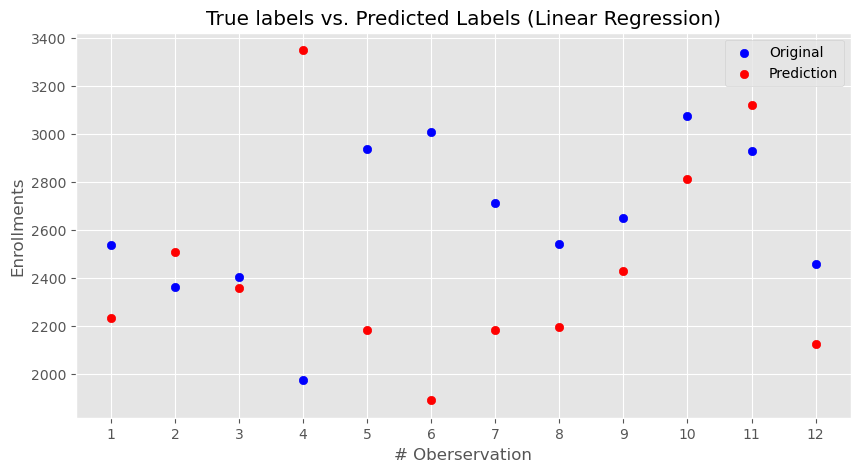

In [212]:
plot_preds(y_test, y_preds, 'Linear Regression')

In [213]:
print(linear_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:             Spend  USD   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              132.3
Date:                Fri, 10 May 2024   Prob (F-statistic):                    7.07e-26
Time:                        13:33:18   Log-Likelihood:                         -351.09
No. Observations:                  47   AIC:                                      720.2
Df Residuals:                      38   BIC:                                      736.8
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

The R2 measures the proportion of how the dependent variable can be explained by the independent variables, from 0-1 where 0 indicates no relationship and 1 indicates it is responsible for all the variance. 
The adjusted R2 accounts for additional variables, adjusting according to the number of predictors in the model and helps to avoid overfitting, a more accurate measure of fit.

In [214]:
pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

,Terms,p_value
7,Experiment,0.005058
0,Number of Impressions,0.015083
3,Number of Searches,0.188854
5,Number of Add to Cart,0.213455
6,Number of Purchase,0.324049
8,DOW,0.376029
4,Number of View Content,0.457228
2,Number of Website Clicks,0.598824
1,Reach,0.681672


The p-value helps indicate whether the null hypothesis should be rejected or accepted. If the p value > 0.05, then it's a good indicator that the null hypothesis should be accepted. In this case, the only p-value that is statsically significant is # of Aa to Cart. 

Model 2: Decision Tree

Decision Trees support non linearity, and are better a predicting categorical independent variables such as gender, marital status. 

In [215]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
dtree.fit(X_train_refined, y_train)
y_preds = dtree.predict(X_test_refined)

calculate_metrics(y_test, y_preds)

RMSE Score: 439.2131451527834
R2_Squared: -1.0574479006924453
MAE Score: 377.6291666666666


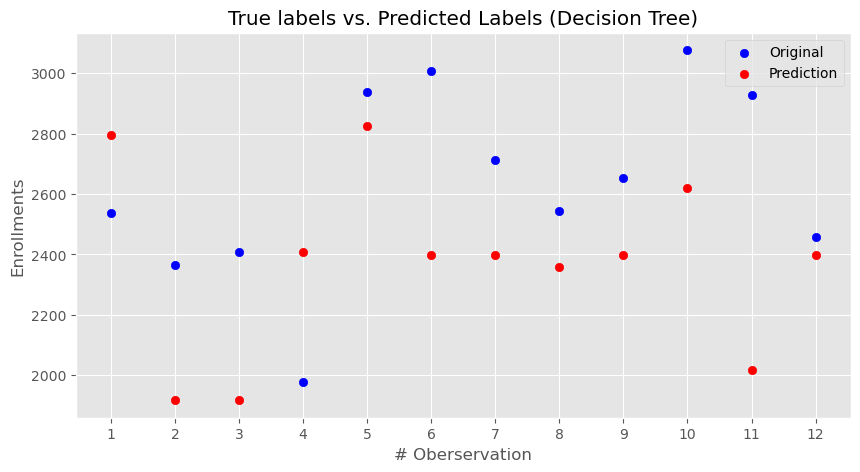

In [216]:
plot_preds(y_test, y_preds, 'Decision Tree')

In [220]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.4 MB/s eta 0:00:00


In [222]:
conda install graphviz

Retrieving notices: ...working... done
Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::numba==0.57.0=py311hdb55bb0_0
  - defaults/noarch::tifffile==2021.7.2=pyhd3eb1b0_2
  - defaults/osx-64::nbclient==0.5.13=py311hecd8cb5_0
  - defaults/osx-64::hvplot==0.8.4=py311hecd8cb5_0
  - defaults/osx-64::pandas==1.5.3=py311hc5848a5_0
  - defaults/osx-64::matplotlib-base==3.7.1=py311h11e8b89_1
  - defaults/osx-64::nbclassic==0.5.5=py311hecd8cb5_0
  - defaults/osx-64::jupyter_server_fileid==0.9.0=py311hecd8cb5_0
  - defaults/osx-64::imbalanced-learn==0.10.1=py311hecd8cb5_1
  - defaults/osx-64::h5py==3.7.0=py311h4bbaca6_0
  - defaults/osx-64::imageio==2.31.1=py311hecd8cb5_0
  - defaults/osx-64::pywavelets==1.4.1=py311h6c40b1e_0
  - defaults/noarch::argon2-cffi==21.3.0=pyhd3eb1b0_0
  - defaults/osx-64::pyerfa==2.0.0=py311h6c40b1e_0
  - defaults/osx-64::arrow-cpp==11.0.0=py311h

Model XG Boost

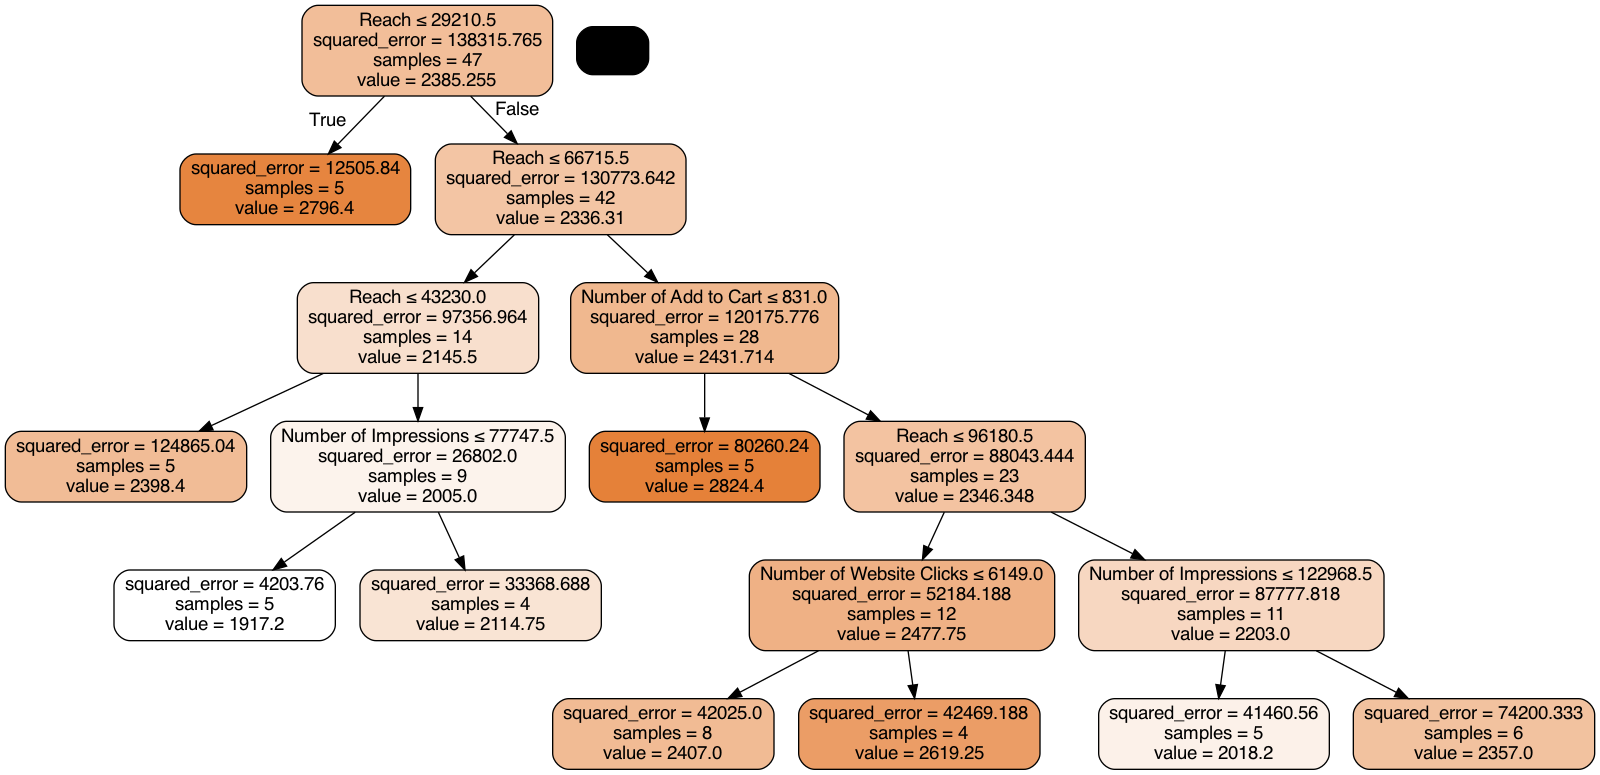

In [230]:
#from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data, 
                feature_names=X_train_refined.columns,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [55]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:0000:0100:01


In [223]:
import xgboost as xgb

In [224]:
DM_train = xgb.DMatrix(data=X_train_refined,label=y_train)
DM_test = xgb.DMatrix(data=X_test_refined,label=y_test)

In [225]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [226]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
    'subsample': 1.
}

In [227]:
xg_reg = xgb.train(params = parameters, dtrain=DM_train, num_boost_round=8)
y_preds = xg_reg.predict(DM_test)

/Users/meme/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/meme/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "gamma", "max_depth", "n_estimators", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


In [228]:
calculate_metrics(y_test, y_preds)

RMSE Score: 368.89363402029943
R2_Squared: -0.4513779103025255
MAE Score: 298.39825439453125


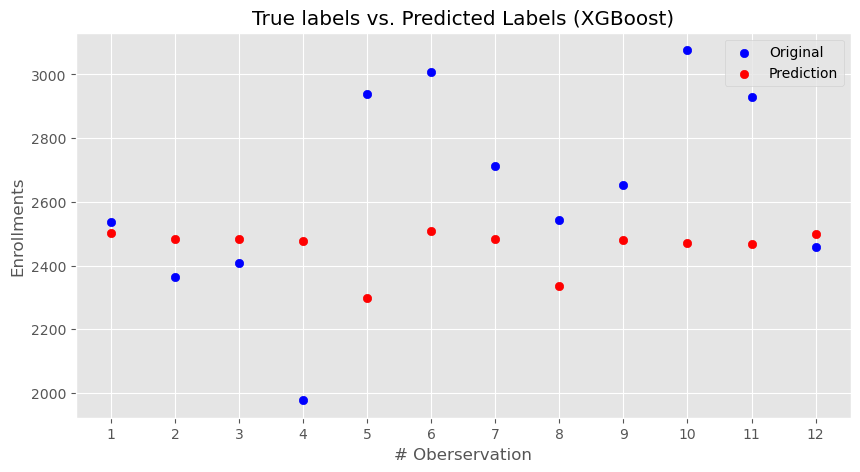

In [229]:
plot_preds(y_test, y_preds, 'XGBoost')